<b>CORONAL HEATING HANDS-ON NOTEBOOK</b>

Our goal is to implement some of the time-steady coronal heating equations of <a href="https://ui.adsabs.harvard.edu/abs/2010ApJ...714.1290M/abstract">Martens (2010)</a> for some idealized coronal loops, and to learn more about how coronal heating works.

For this first part, we will see how much heating is required to produce the "typical" active-region loop defined by <a href="https://ui.adsabs.harvard.edu/abs/2004ApJ...615..512S/abstract">Schrijver et al. (2004)</a> as a baseline.

***

First, let's set up the necessary python imports, and define some physical constants (all Gaussian/cgs).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import special

In [2]:
xRsun = 6.96e10
boltzk = 1.380622e-16
xmHyd = 1.677333e-24

Here are the parameters of Schrijver's typical active-region loop:  peak temperature of 3 million K, footpoint field strength of 100 Gauss, and a length of 30 Mm.

In [3]:
Tmax = 3.0e6    # peak temperature at loop apex (in K)
B0 = 100.       # constant magnetic field along loop (in G)
L = 30. * 1.e8  # loop length = 30 Mm

Here are some "constants" for coronal loops that we won't need to vary very often...

In [4]:
lamperp = 120. * 1.e5         # photospheric length scale = 120 km
vperp0 = 1.0 * 1.e5           # fiducial photospheric velocity = 1 km/s
xkap0 = 1.1e-6                # kappa_0 electron conductivity constant
chi0 = 2.5703958e12           # Martens' chi_0 radiative loss constant
Tbase = 1.e4                  # temperature at TR ("coronal base")
gpiet = 0.5                   # Martens' gamma exponent (from radiative loss function)
gadia = 5./3.                 # adiabatic gamma exponent for an ideal gas
grav0 = 2.7399993e4           # solar surface gravity GM/R^2

Following Schrijver, we should take account of how photospheric velocity depends on magnetic field strength.  This formula doesn't make strong changes to "vperp0" unless B0 is ~1000 Gauss or more (starting to get into sunspot territory).

In [5]:
vperp = vperp0 * np.exp(-(B0/500.)**2)

***

<b>TASK 1:</b>  For an initial guess of the $(m,n)$ exponents (as well as the simplest guess for the flux-tube expansion exponent $\delta$), we can figure out how much heating is required to make the model work.

In [6]:
emm = 0.
enn = 0.
dpiet = 0.

For these parameters, define many of the necessary Martens (2010) scaling-law variables

In [7]:
bpiet = 0.5*emm
apiet = (emm-2.)*dpiet - bpiet
nu = (apiet + dpiet) / (3.5 + dpiet)     #  eqn (45)
mu = (dpiet - 2. - gpiet) / (3.5 + dpiet)     # eqn (46)
lampiet = (1. - 2.*nu + mu) / (2.*(nu - mu))      # eqn (18)
Blam = special.beta((lampiet+1.),0.5)          # "complete" beta function
CCC1 = np.sqrt(xkap0/chi0) * np.sqrt(3.-2.*gpiet+2.*dpiet) / (4.+2.*gpiet+2.*apiet) * Blam
CCC2 = chi0 * (3.5 + apiet) / (1.5 - gpiet + 2.*dpiet)
eeeP = (11. + 2.*gpiet) / 4.
eeeT = 1. / (2. + gpiet + apiet - 2.*eeeP + bpiet*eeeP)

Some of these quantities are derived from Martens' expressions as follows:

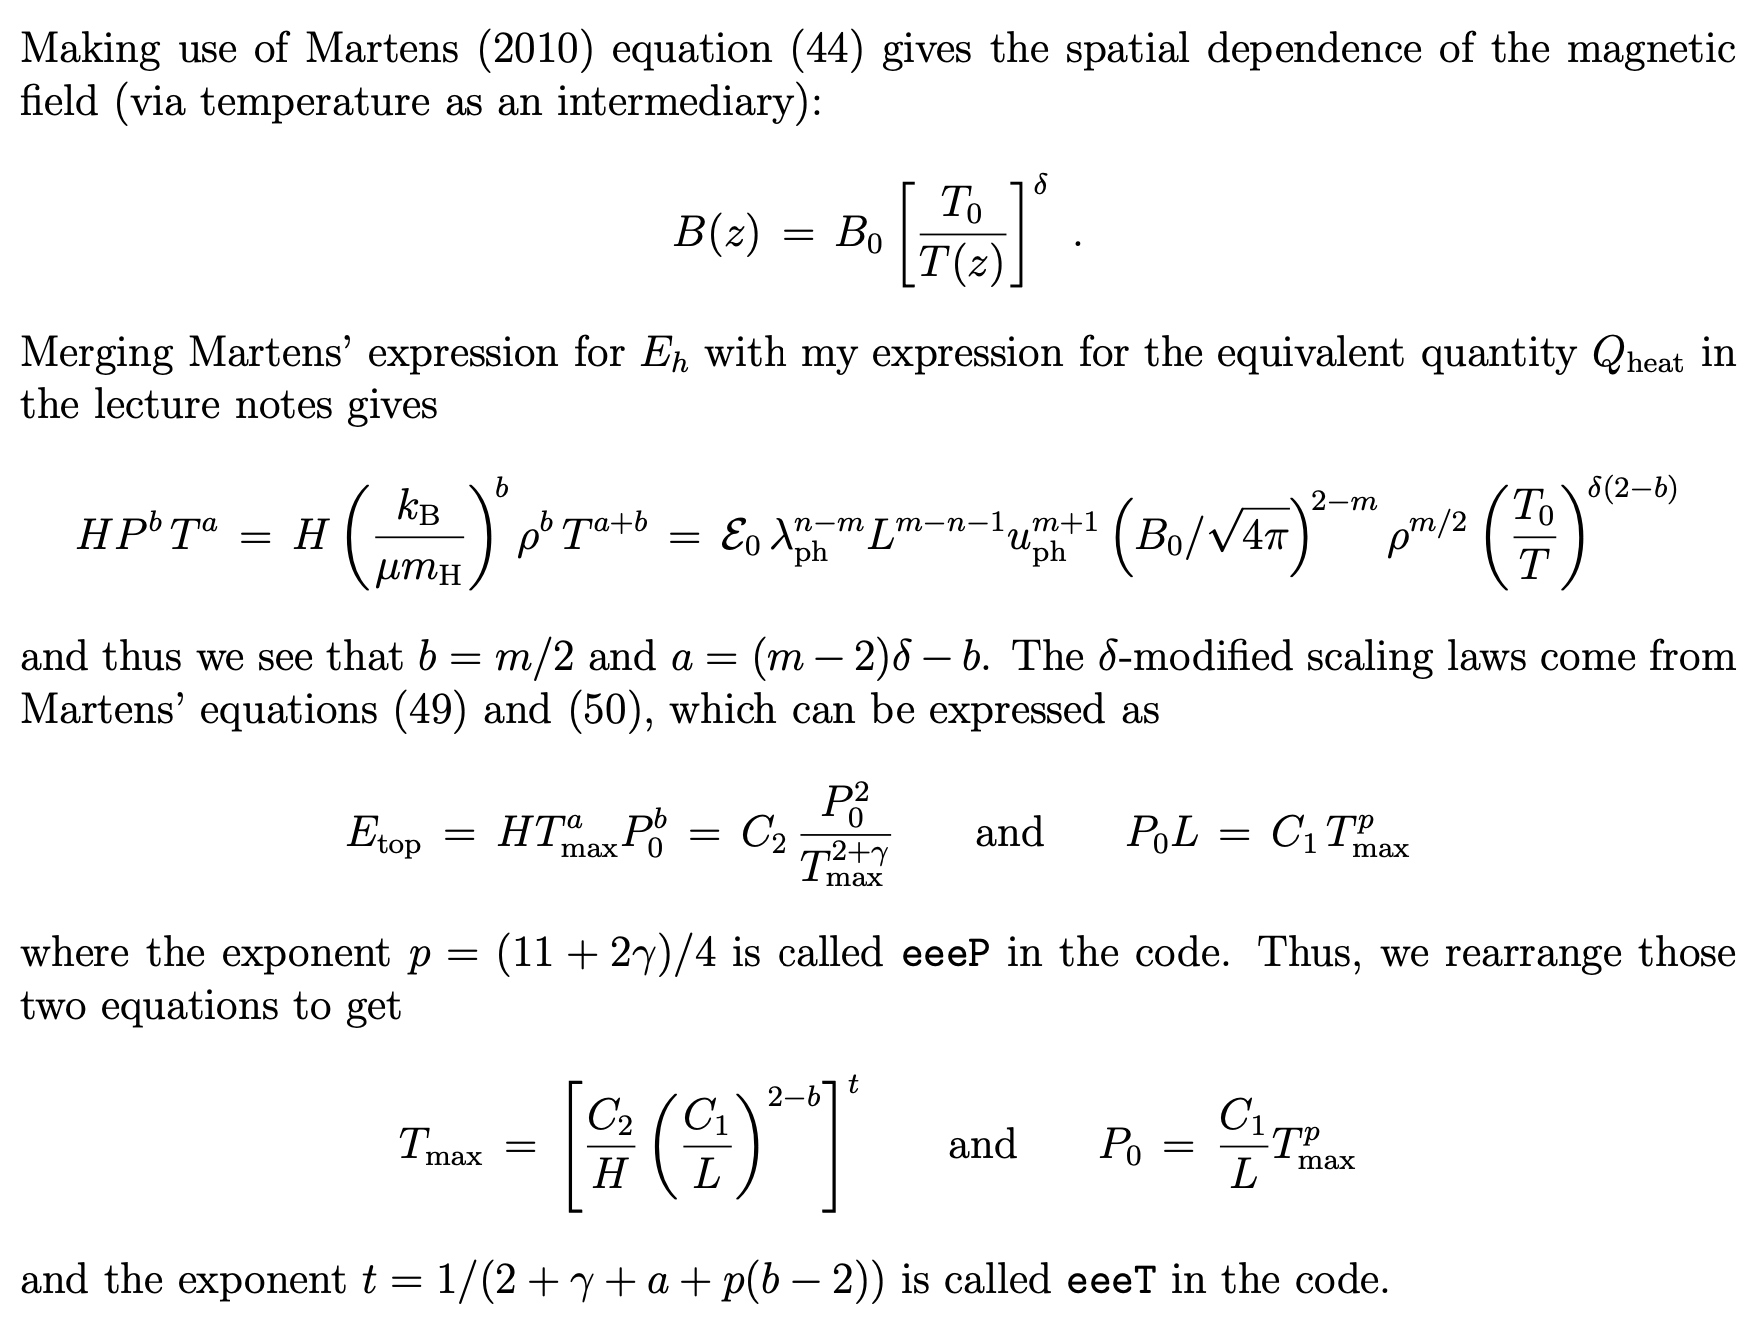

In this situation, though, we know $T_{\rm max}$, and we want to get the heating constant $H$ from it.

In [8]:
Hpiet = CCC2 / (Tmax**(1./eeeT)) * ((CCC1/L)**(2.-bpiet))

<font color=red><b>For you to try:</b></font> Use $H$ (i.e., the variable Hpiet) to re-compute $T_{\rm max}$ to make sure we've done everything properly.

<font color=red><b>For you to try:</b></font> Also, you can compare Martens' scaling law for $T_{\rm max}$ (in terms of $H$ and $L$) with the much simpler version derived (without $Q_{\rm rad}$) in the lecture notes.  How close does the simpler version come to the more complete solution (say, for $m=n=0$)?

***

For this model, we can then compute the base pressure, base density (assuming the corona is pure hydrogen and fully ionized), Poynting flux at the base, efficiency ($\cal E$), and coronal heating flux at the base.

In [9]:
P0 = CCC1 * Tmax**eeeP / L
ne0 = P0 / (2.0*boltzk*Tbase)
rho0 = ne0*xmHyd

Qbase = Hpiet * (P0**bpiet) * (Tbase**apiet)
VA_base = B0/np.sqrt(4.*np.pi*rho0)
Poynt_base = rho0 * (VA_base**2) * vperp
Flux_base = Qbase * L
efficiency = Flux_base / Poynt_base

Do the answers make sense?

In [10]:
print(' ')
print(' base flux:  ',Flux_base/1.e6,'  kW/m2 ')
print(' efficiency: ',efficiency,'  [should be < 1]')

 
 base flux:   15.401614264844675   kW/m2 
 efficiency:  0.20144100780520244   [should be < 1]


<font color=red><b>For you to try:</b></font> Compute the time scales $\tau_{\rm A}$ and $\tau_{\rm ph}$ for this loop.  From these, you can compute the efficiency normalization ${\cal E}_0$ (which can be used for other loops). You can also see whether we're in the "AC" or "DC" regimes!

***

<b>TASK 2:</b>  Solve for the spatial dependence of temperature and density, assuming constant pressure along the loop.  This is what Martens assumed, but we really ought to examine that assumption.

First, we need to create a linear grid in temperature along the loop, then we can solve for spatial position "z" along the loop using Martens' incomplete beta function...

In [11]:
nz = 2000
Tloop = np.linspace(Tbase,Tmax,num=nz)
eta = (Tloop/Tmax)**(3.5 + dpiet)
uloop = eta**((2.+gpiet+apiet)/3.5)
zcmloop = (L/2.) * special.betainc((lampiet+1.),0.5,uloop)     # incomplete, regularized beta function
zMmloop = zcmloop / 1.e8

neloop = P0/(2.0*boltzk*Tloop)

Let's look at $T(z)$ and compare it with the analytic estimate the lecture notes.

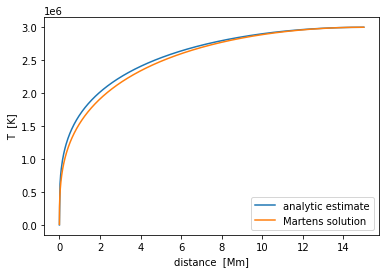

In [12]:
zcm_simple = np.linspace(0.,L/2.,num=500)
T_simple = Tmax * (1. - (zcm_simple/(L/2.) - 1.)**2)**(2./7.)

plt.plot(zcm_simple/1.e8,T_simple,label='analytic estimate')
plt.plot(zMmloop,Tloop,label='Martens solution')
plt.xlabel('distance  [Mm]')
plt.ylabel('T  [K]')
plt.legend();

I was actually surprised the analytic estimate is so close to the beta-function thing!

But do we really expect $P$ to stay constant at a value of $P_0$ along the whole loop?  Let's compute the pressure scale height and estimate how $P$ and $n_e$ depend on height (assuming height = "z" along loop) in the two cases.

In [13]:
cs2max = gadia*boltzk*Tmax/(0.5*xmHyd)
Hmax = cs2max / (gadia*grav0)
P_better = P0 * np.exp(-zcmloop/Hmax)
ne_better = P_better / (2.0*boltzk*Tloop)

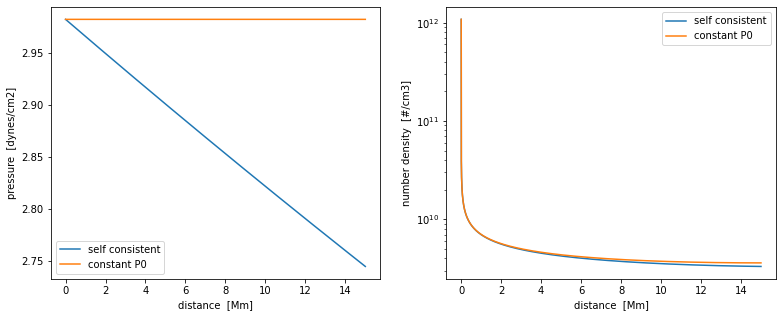

In [14]:
plt.figure(figsize=[13,5])
plt.subplot(121)
plt.plot(zMmloop,P_better,label='self consistent')
plt.plot(zMmloop,np.full(nz,P0),label='constant P0')
plt.xlabel('distance  [Mm]')
plt.ylabel('pressure  [dynes/cm2]')
plt.legend();
plt.subplot(122)
plt.yscale("log")
plt.plot(zMmloop,ne_better,label='self consistent')
plt.plot(zMmloop,neloop,label='constant P0')
plt.xlabel('distance  [Mm]')
plt.ylabel('number density  [#/cm3]')
plt.legend();

<font color=red><b>For you to try:</b></font> Note that I was kind of cheating with hydrostatic equilibrium.  I used an expression for constant temperature... and I assumed $T_{\rm max}$ for that temperature!  That <i>underestimates</i> how much radial drop-off there will be in the pressure and density.  To do better, you'd need to integrate the equation of hydrostatic equilibrium numerically, but it would be interesting to see how much of a change that makes!

***

<b>TASK 3:</b>  For this active region model (with $\delta = 0$), we should determine what range of parameters for $(m,n)$ are consistent with producing an efficiency ${\cal E}$ that is less than 1.

Note, however, that $n$ (i.e., the variable "enn") was actually <i>never used</i> above!  The only place it would come into play would be in the calculation of ${\cal E}_0$, which we left as an exercise.  Thus, we only need to vary $m$.  In other words, repeat the above calculations using a grid of $m$ values...

In [15]:
nemm = 2000
emm_min = -3.
emm_max = 3.
emm = np.linspace(emm_min,emm_max,num=nemm)

I'm just going to copy lots of stuff from above, but now nearly every variable that used to be a scalar is now an array.

In [16]:
bpiet = 0.5*emm
apiet = (emm-2.)*dpiet - bpiet
nu = (apiet + dpiet) / (3.5 + dpiet)     #  eqn (45)
mu = (dpiet - 2. - gpiet) / (3.5 + dpiet)     # eqn (46)
lampiet = (1. - 2.*nu + mu) / (2.*(nu - mu))      # eqn (18)
Blam = special.beta((lampiet+1.),0.5)
CCC1 = np.sqrt(xkap0/chi0) * np.sqrt(3.-2.*gpiet+2.*dpiet) / (4.+2.*gpiet+2.*apiet) * Blam
CCC2 = chi0 * (3.5 + apiet) / (1.5 - gpiet + 2.*dpiet)
eeeP = (11. + 2.*gpiet) / 4.
eeeT = 1. / (2. + gpiet + apiet - 2.*eeeP + bpiet*eeeP)

In [17]:
Hpiet = CCC2 / (Tmax**(1./eeeT)) * ((CCC1/L)**(2.-bpiet))

P0 = CCC1 * Tmax**eeeP / L
ne0 = P0 / (2.0*boltzk*Tbase)
rho0 = ne0*xmHyd

Qbase = Hpiet * (P0**bpiet) * (Tbase**apiet)
VA_base = B0/np.sqrt(4.*np.pi*rho0)
Poynt_base = rho0 * (VA_base**2) * vperp
Flux_base = Qbase * L
efficiency = Flux_base / Poynt_base

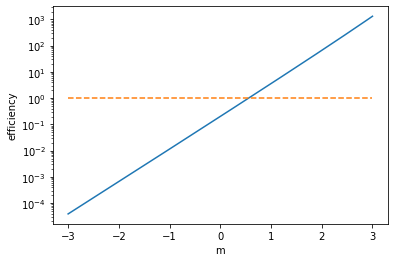

In [18]:
plt.plot(emm,efficiency)
plt.plot(np.array([emm_min,emm_max]),np.array([1.,1.]),'--')
plt.yscale("log")
plt.xlabel('m')
plt.ylabel('efficiency');

In [19]:
from scipy import interpolate
interp = interpolate.interp1d(efficiency,emm,kind="linear")
emm_crit = interp(1.)
print(' ')
print(' The value of m when efficiency=1 is: ',emm_crit)

 
 The value of m when efficiency=1 is:  0.5571160463332986


In the lecture notes, we estimated that the range of exponents that make sense is $-1 < m < 2$.  Here, we seem to have squeezed that range down a bit to $-1 < m < 0.557$.  However, we haven't yet put any constraints on $n$.

***

<font color=red><b>For you to try:</b></font> What if we tried to find a consistent model that explains both Schrijver's typical active-region loop, <b>and</b> a typical large Quiet-Sun loop with the following properties:

In [63]:
B0_qs = 2.             # constant magnetic field along loop (in G)
L_qs = 630. * 1.e8       # loop length = 630 Mm

By "consistent" I mean that, for given choices of $(m,n)$, we must use the <i>same</i> value of ${\cal E}_0$ for the active-region model and the quiet-sun model.

Let's also assume that $\delta$ (i.e., the variable dpiet) is equal to zero for these kinds of loops, too (though that's not as good an assumption as for the short loops in active regions).

Your goal:  For each point in a grid of $(m,n)$ values, first compute ${\cal E}_0$ for the active-region loop, then figure out $H$ for the Quiet-Sun loop, and then compute its other properties (e.g., $T_{\rm max}$, $P_0$, Poynting flux, efficiency).  There will only be a restricted range of the $(m,n)$ plane that satisfies ALL of the following conditions:

1. efficiency for the active-region loop is < 1,
2. efficiency for the quiet-sun loop is < 1,
3. $T_{\rm max}$ for the quiet-sun loop is between 1 and 2.5 million K.

In the spirit of problems that ask you to "show that" certain things are true, I'll show you the answer that I got, and your job is to reproduce it.  The green region below is all that seems to be allowed:

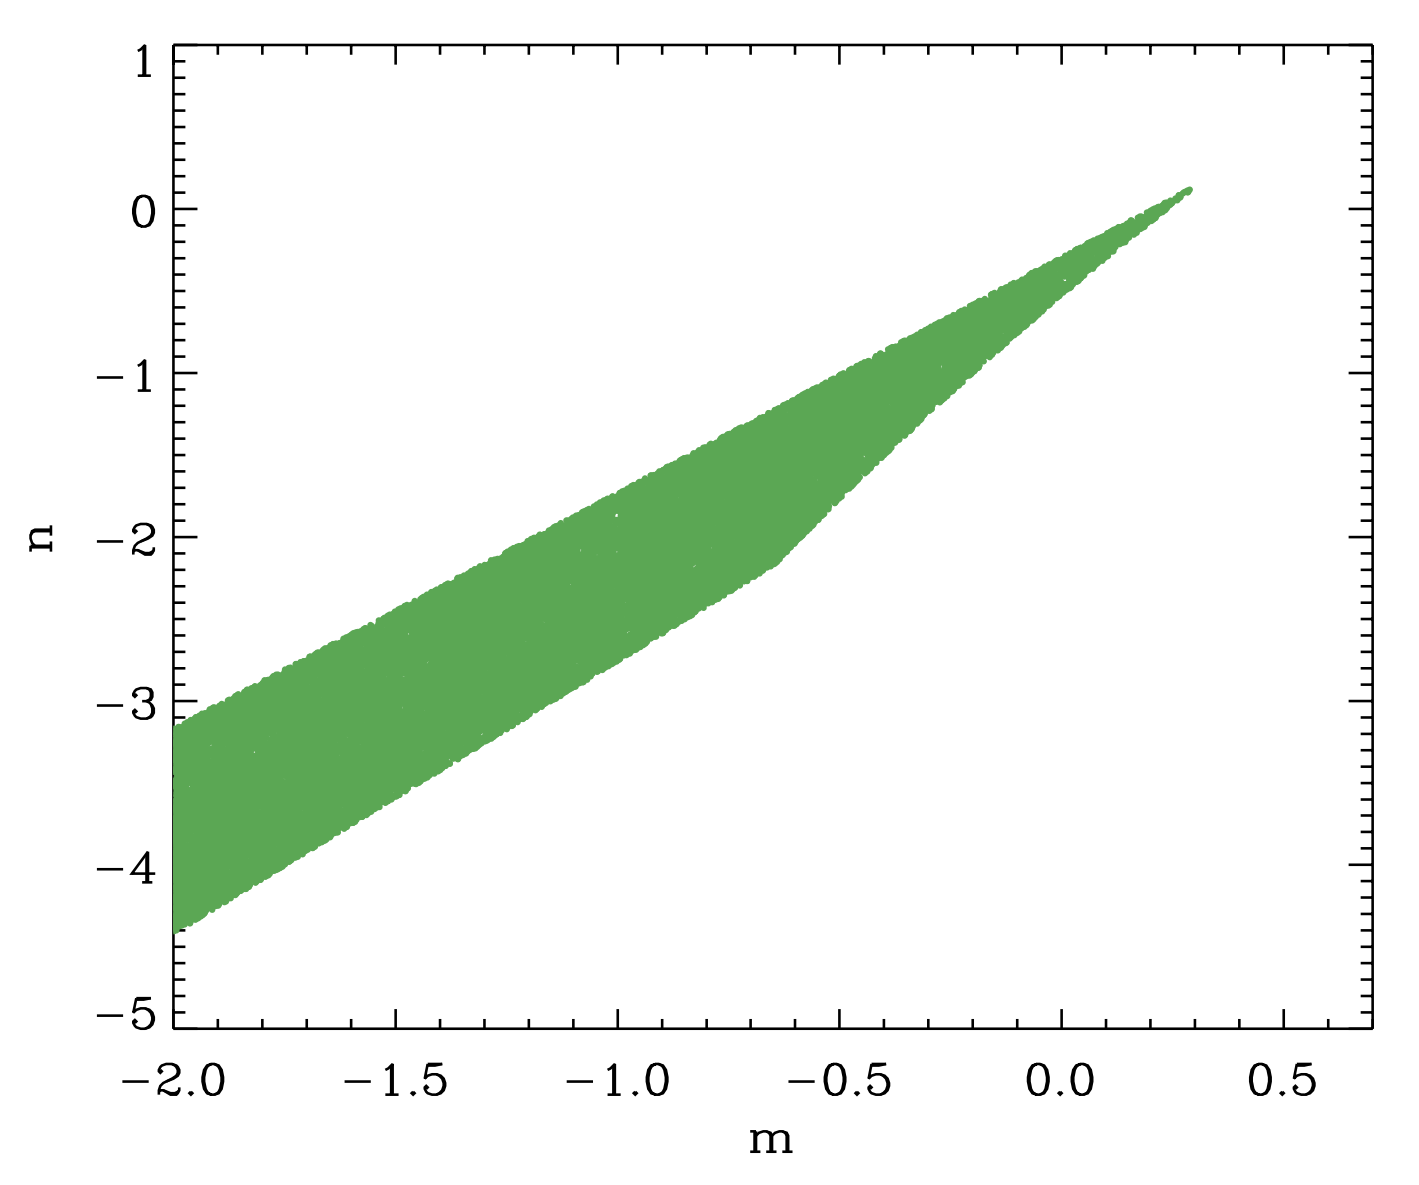

<font color=red><b>Other things for you to explore:</b></font>

* How do the properties of the heating change for nonzero values of $\delta$?  Section 3.5 of Martens (2010) discusses it a bit, but there's more to explore.  For example, Table 1 of <a href="https://ui.adsabs.harvard.edu/abs/2016ApJ...831...10S/abstract">Schiff & Cranmer (2016)</a> gives the information needed to compute $\delta$ as a function of loop-length $L$ for large Quiet-Sun loops.  How does the coronal heating vary if one implements that, and holds everything else constant?

* Use <a href="https://ui.adsabs.harvard.edu/classic-form">ADS</a> to search for papers that propose to solve the coronal heating problem.  If any of those papers gives an analytic expression for the heating rate, can you implement it in $(m,n)$ notation to see how it might work?

* We didn't look too closely at the output values of base pressure ($P_0$) for different parameters.  What would it take to reproduce the plot (from the lecture slides) of empirical base pressures as a function of magnetic activity?  See:
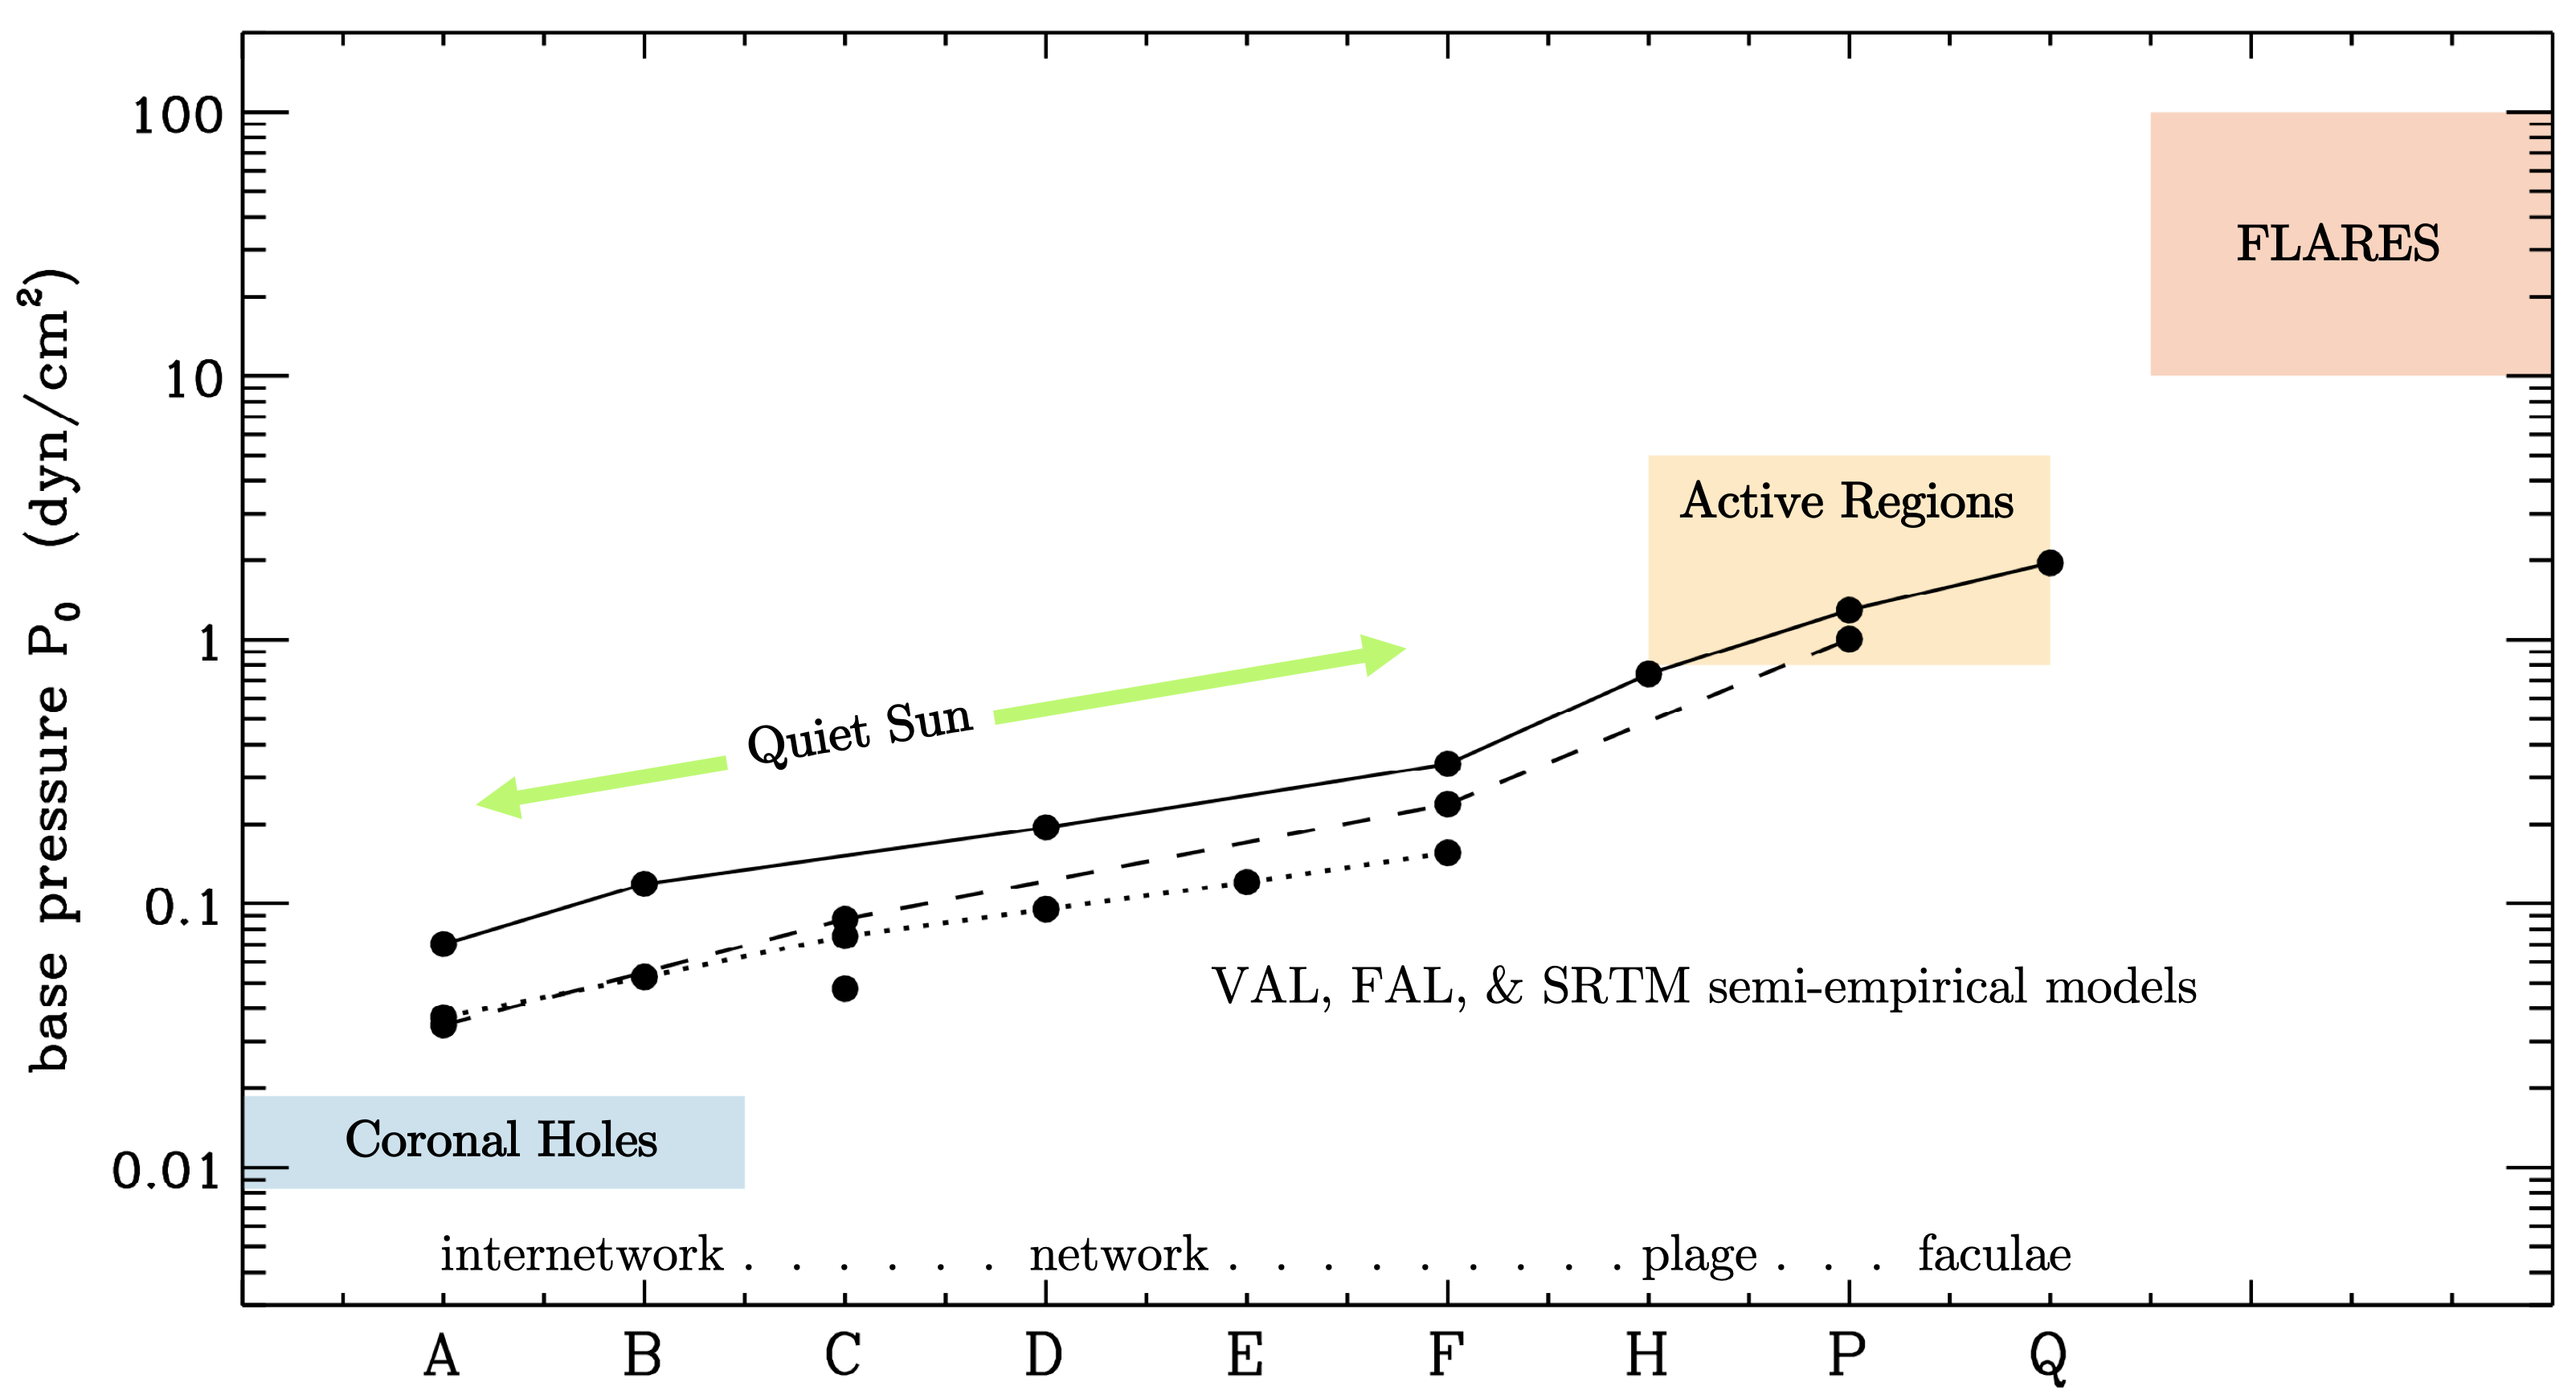